# Are word counts correlated with profit margin?
### This is a simplistic experiment but could be more robust

### Software (Python jupyter Pandas) is industry standard



In [1]:
%pip install "calcbench-api-client[Pandas, Backoff, BeautifulSoup]" tqdm scipy seaborn nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

from tqdm.notebook import tqdm


from scipy.special import expit
import seaborn as sns
from collections import Counter
from typing import Iterable

import calcbench as cb
import nltk


cb.enable_backoff()
tqdm.pandas(desc="progress")

## Get the documents and build dictionaries of word counts
### Calcbench extracts MD&A (Management Discussion and Analysis) from 10-K/Qs

In [3]:
tickers = cb.tickers(index="SP500")  # can use any list of tickers

In [4]:
tickers = tickers[:4]

In [5]:
disclosure_names = ["ManagementsDiscussionAndAnalysis"] # full list available @ 

with tqdm() as progress_bar:
    disclosures = cb.document_dataframe(
        company_identifiers=tickers,
        disclosure_names=disclosure_names,
        all_history=True,
        period_type="annual",
        progress_bar=progress_bar,
        # entire_universe=True,
    )
    
disclosures.index.name = 'fiscal_period'
    
def get_contents(d):
    try:
        return d.get_contents_text()
    except Exception as e:
        print(f"Exception getting {d} \n{e}")


disclosure_contents = disclosures.progress_applymap(
    get_contents, na_action="ignore"
).fillna("")

disclosure_embeddings = disclosure_contents.progress_applymap(
    lambda c: Counter(word.lower() for word in nltk.word_tokenize(c))
)

0it [00:00, ?it/s]

c:\users\andre\repos\python_api_client\calcbench\disclosures.py:264: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'Y' instead.
  pandas_period = pd.Period(year=period_year, freq="A")  # type: ignore


progress:   0%|          | 0/72 [00:00<?, ?it/s]

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return getattr(df, df_function)(wrapper, **kwargs)


progress:   0%|          | 0/72 [00:00<?, ?it/s]

## Find occurrences of terms

In [6]:
terms = ["inflation", "supply", "inflationary"]

def distance(word_counts: Counter, category_words: Iterable[str]):
    return sum(count for word, count in word_counts.items() if word in category_words)

category_distances = disclosure_embeddings.progress_applymap(
    lambda word_counts: distance(word_counts, terms)
)

progress:   0%|          | 0/72 [00:00<?, ?it/s]

## Get standardized Profit Margin
### Can get any of the metrics from https://www.calcbench.com/home/standardizedmetrics

In [31]:
metric = "GrossProfitMargin"  # Can use any of the calcbench standardized metrics

profit_margin = cb.standardized(
    company_identifiers=tickers,
    metrics=[metric],
    period_type="annual",
).unstack("metric")["value"][[metric]]

In [32]:
# make the fiscal period just the fiscal year
profit_margin.index = profit_margin.index.set_levels(
    profit_margin.index.get_level_values("fiscal_period")
    .str.split("-", expand=True)
    .get_level_values(0),
    level=1,
    verify_integrity=False
)

## Correlation of period profit margin and inflation terms

In [9]:
total_word_counts = disclosure_embeddings.progress_applymap(lambda w: sum(w.values()))

progress:   0%|          | 0/72 [00:00<?, ?it/s]

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return getattr(df, df_function)(wrapper, **kwargs)


In [41]:
distance_to_word_count = (category_distances[["ManagementsDiscussionAndAnalysis"]] / total_word_counts[
    ["ManagementsDiscussionAndAnalysis"]
]).stack()

C:\Users\andre\AppData\Local\Temp\ipykernel_8912\3349284359.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ]).stack()


In [75]:
d = expit(profit_margin).join(distance_to_word_count)

In [66]:
d = (
    pd.DataFrame(
        data=[
            "profit_margin": ]expit(profit_margin),
            "inflation_count": distance_to_word_count,
        }
    )
    .swaplevel()
    .sort_index()
)

C:\Users\andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\internals\construction.py:575: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


TypeError: Can only swap levels on a hierarchical axis.

In [77]:
d

GrossProfitMargin  ManagementsDiscussionAndAnalysis
ticker fiscal_period                                                     
ABBV   2013                    0.673812                          0.000089
       2014                    0.675696                          0.000076
       2015                    0.680209                          0.000072
       2016                    0.680528                          0.000083
       2017                    0.685304                          0.000087
       2018                    0.690646                          0.000093
       2019                    0.684067                          0.000093
       2020                    0.679271                          0.000508
       2021                    0.682299                          0.000297
       2022                    0.684899                          0.000299
       2023                    0.660174                          0.000191
       2007                    0.665868                               NaN
       2008                    0.668196                               NaN
       2009                    0.651163                               NaN
ABT    2010                    0.636276                          0.000083
       2011                    0.639426                          0.000065
       2012                    0.638909                          0.000286
       2013                    0.641753                          0.000430
       2014                    0.629965                          0.000436
       2015                    0.630150                          0.000356
       2016                    0.630026                          0.000315
       2017                    0.632910                          0.000293
       2018                    0.639070                          0.000188
       2019                    0.637354                          0.000000
       2020                    0.633428                          0.000000
       2021                    0.642096                          0.000544
       2022                    0.642283                          0.001347
       2023                    0.637952                          0.000843
       2007                    0.638684                          0.000223
       2008                    0.636799                          0.000212
       2009                    0.634564                          0.000109
ACN    2011                    0.570492                          0.000152
       2012                    0.573280                          0.000158
       2013                    0.577853                          0.000149
       2014                    0.576058                          0.000153
       2015                    0.574888                          0.000166
       2016                    0.576580                          0.000158
       2017                    0.575378                          0.000188
       2018                    0.573959                          0.000186
       2019                    0.573305                          0.000228
       2020                    0.575918                          0.000264
       2021                    0.575608                          0.000296
       2022                    0.576422                          0.000567
       2023                    0.578177                          0.000385
       2007                    0.580257                               NaN
       2008                    0.579290                               NaN
       2009                    0.580144                          0.000071
       2010                    0.580808                          0.000066
MMM    2010                    0.617605                          0.000307
       2011                    0.615511                          0.000431
       2012                    0.616879                          0.000404
       2013                    0.618042                          0.000408
       2014               

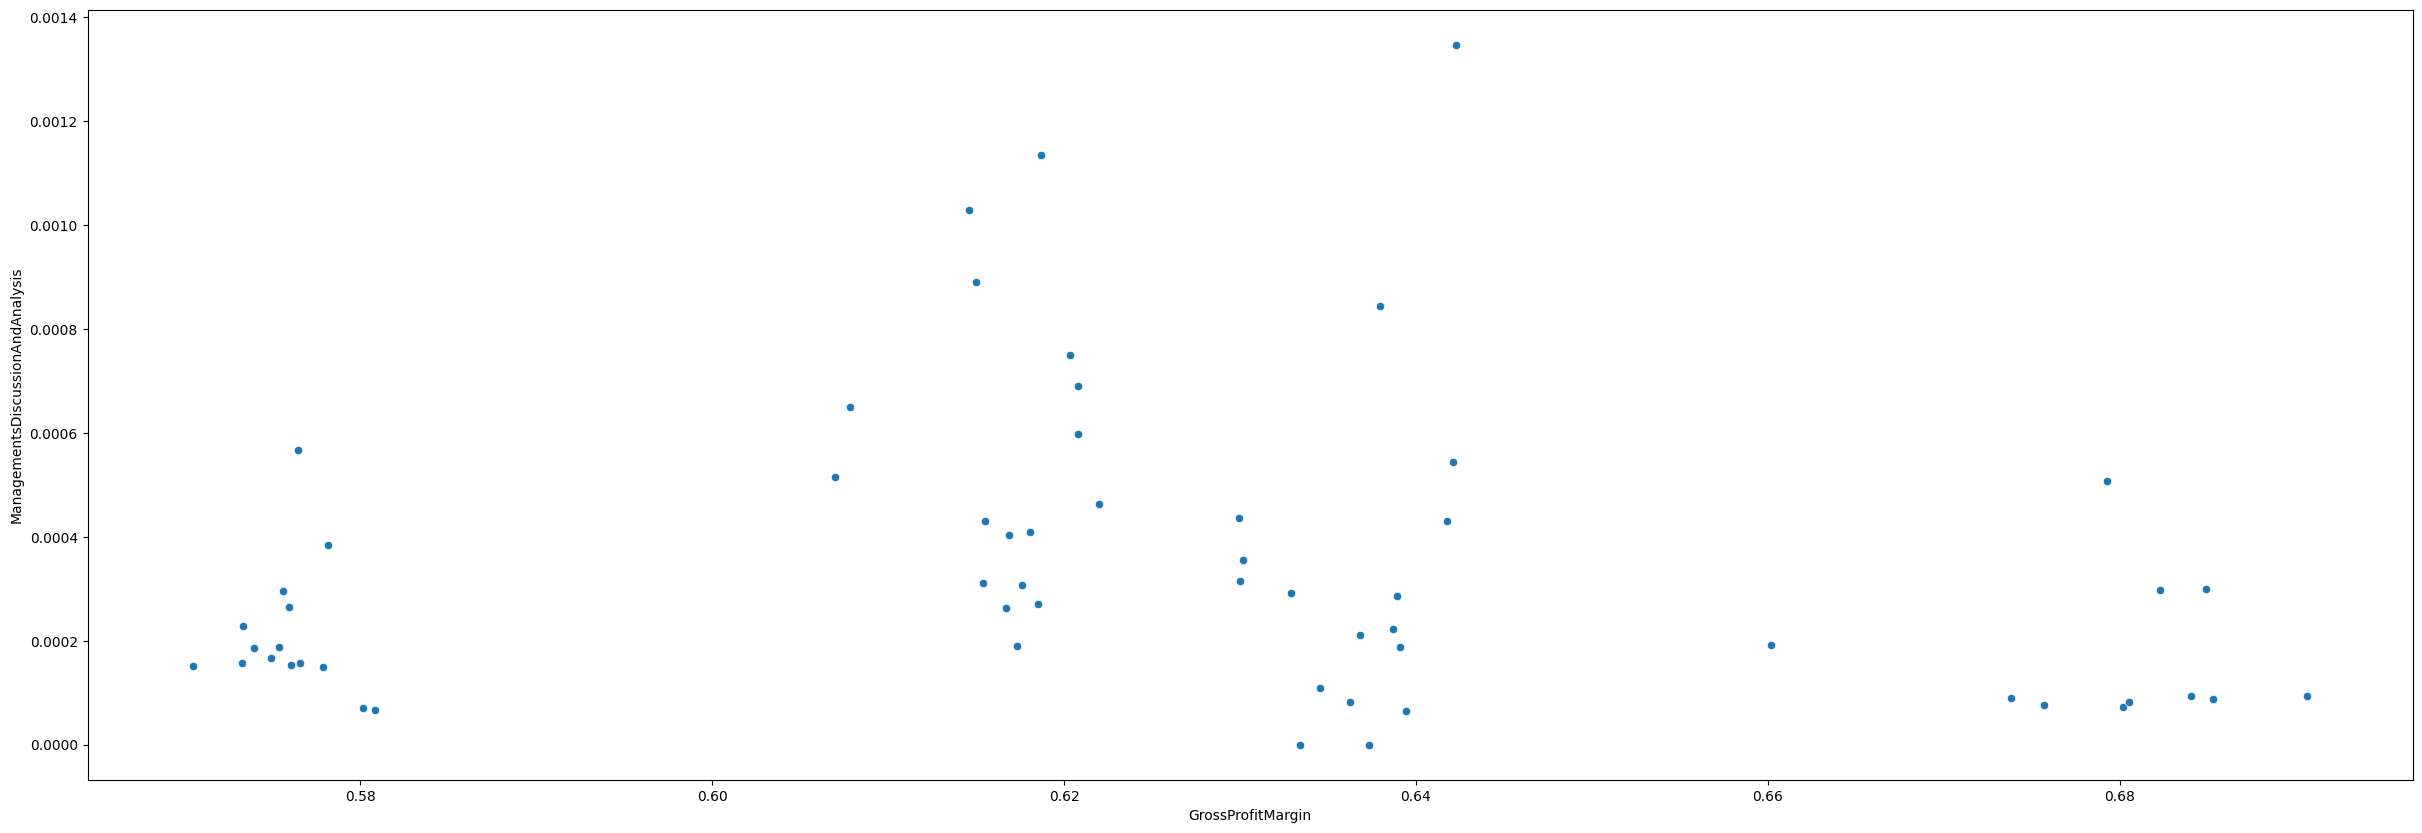

In [78]:
g = sns.scatterplot(x="GrossProfitMargin", y="ManagementsDiscussionAndAnalysis", data=d)
g.figure.set_figheight(10)
g.figure.set_figwidth(30)

## How has term count changed over time?

### How frequently do the terms "inflation", "supply", "inflationary" appear in the Management Discussing and Analysis

### History and Industry Breakdown

In [16]:
SIC_code = cb.standardized(
    company_identifiers=tickers,
    metrics=["SIC_code"],    
    period_type="annual",
).unstack("metric")['value']

In [17]:
two_digit_SIC_codes = pd.to_numeric(
    SIC_code["SIC_code"] // 100, downcast="integer"
).astype(str)
two_digit_SIC_codes.name = "SIC_Code"

In [18]:
def industry_group(c):
    try:
        two_digit_SIC_code = int(two_digit_SIC_codes[c[1]])
    except KeyError:
        return None
    else:
        if two_digit_SIC_code < 9:
            return "Agriculture"
        elif 10 <= two_digit_SIC_code <= 14:
            return "Mining"
        elif 15 <= two_digit_SIC_code <= 17:
            return
            return "Construction"
        elif 20 <= two_digit_SIC_code <= 39:
            return "Manufacturing"
        elif 40 <= two_digit_SIC_code <= 49:
            return
            return "Transportation"
        elif 50 <= two_digit_SIC_code <= 51:
            return "Wholesale Trade"
        elif 52 <= two_digit_SIC_code <= 59:
            return "Retail Trade"
        elif 60 <= two_digit_SIC_code <= 67:
            return 
            return "Finance"
        elif 70 <= two_digit_SIC_code <= 89:
            return "Services"

In [19]:
tf_document_length = category_distances / total_word_counts
industry_averages = tf_document_length.groupby(by=industry_group, axis=1).mean()

C:\Users\andre\AppData\Local\Temp\ipykernel_8912\640827809.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  industry_averages = tf_document_length.groupby(by=industry_group, axis=1).mean()
C:\Users\andre\AppData\Local\Temp\ipykernel_8912\3035938948.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  two_digit_SIC_code = int(two_digit_SIC_codes[c[1]])


<Axes: xlabel='fiscal_period'>

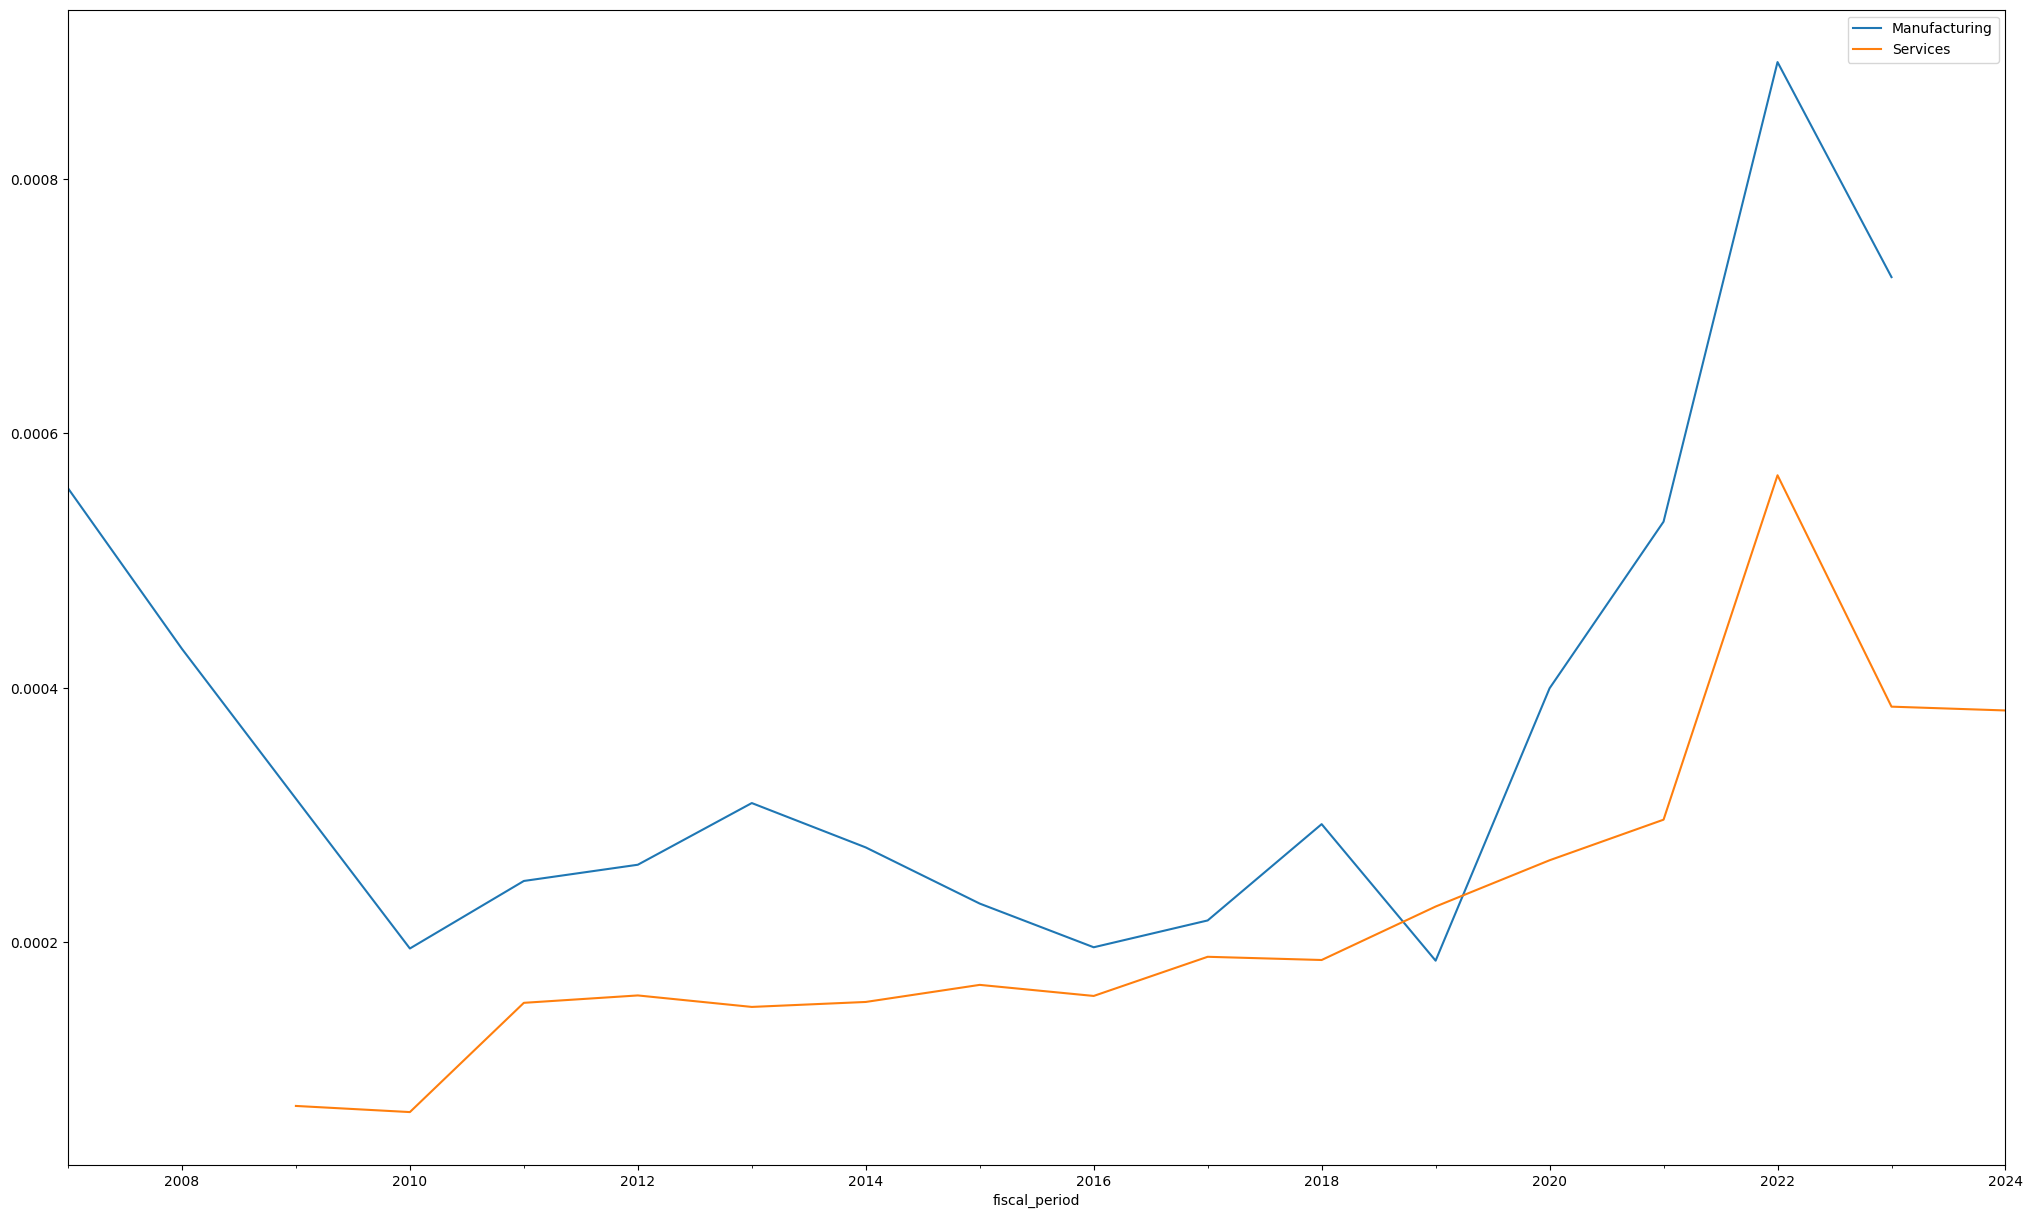

In [20]:
industry_averages.plot(figsize=(25, 15))